Import Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,  Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import cv2
from PIL import Image
import pydotplus
from sklearn import tree
from io import BytesIO
import warnings
import pickle
import tensorflow as tf
import random
warnings.filterwarnings("ignore")
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'



Preprocessing The sampled Dtataset

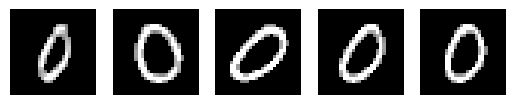

In [35]:
# Function to reduce blur with Gaussian blur reduction
def reduce_blur(image):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image

# Function to gently sharpen the image
def gentle_sharpen(image):
    sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image_8bit = np.uint8(image * 255)
    sharpened_image = cv2.filter2D(image_8bit, -1, sharpening_kernel)
    return sharpened_image / 255.0

# Function to enhance contrast
def enhance_contrast(img):
    img_8bit = np.uint8(img * 255)
    equalized_img = cv2.equalizeHist(img_8bit)
    return equalized_img / 255.0

# Function to apply soft thresholding
def soft_threshold(image, threshold=0.5):
    thresholded_image = np.where(image < threshold, 0, image)
    return thresholded_image

# Load and process image
def load_image(img_path, img_size=(28, 28)):
    try:
        img = Image.open(img_path).convert("L").resize(img_size)
        img = np.array(img) / 255.0
        img = reduce_blur(img)
        img = gentle_sharpen(img)
        img = enhance_contrast(img)
        img = soft_threshold(img, threshold=0.5)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return np.zeros((img_size[0], img_size[1]))

# Load dataset
data = pd.read_csv("synthetic_mnist_dataset/labels.csv")
data.columns = ['img_path', 'label']

# Process images and labels
X = np.array([load_image(path) for path in data['img_path']])
y = np.array(data['label'])

# Visualize processed images
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i + 1000], cmap='gray')
    plt.axis('off')
plt.show()

df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['label'] = y
df_unique = df.drop_duplicates()

# Split unique dataset into features and labels
X_unique = df_unique.iloc[:, :-1].to_numpy()
y_unique = df_unique.iloc[:, -1].to_numpy()

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_unique, y_unique, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




Train the CNN and Decisition Tree model

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
Validation Accuracy: 0.90
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
Test Accuracy: 0.9055
              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00      1028
     Class 1       1.00      1.00      1.00      1053
     Class 2       1.00      1.00      1.00      1049
     Class 3       0.53      1.00      0.69      1017
     Class 4       0.99      0.99      0.99      1087
     Class 5       0.98      0.99      0.98      1119
     Class 6       1.00      1.00      1.00      1073
     Class 7       1.00      1.00      1.00      1054
     Class 8       0.98      0.06      0.12      1010
     Class 9       0.96      1.00      0.98      1011

    accuracy                           0.91     10501
   macro avg       0.94      0.90      0.88     10501
weighted avg       0.95      0.91      0.88     10501

True Predictions:


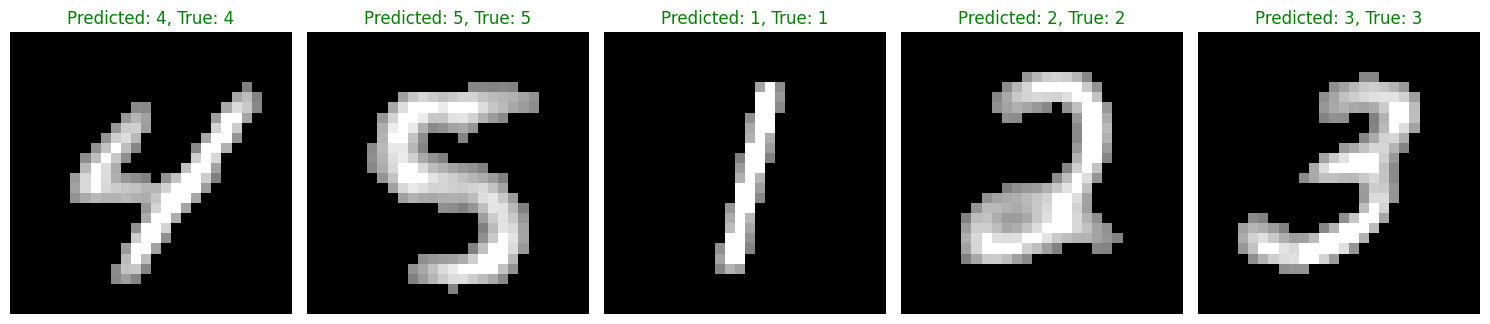

False Predictions:


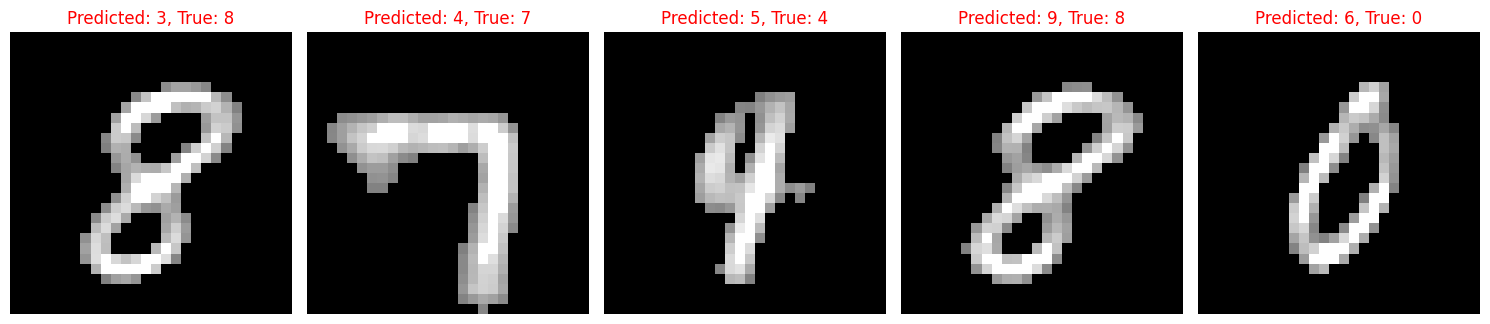

In [38]:
class CNN_DT_Classifier:
    def __init__(self, image_shape, learning_rate=1e-6, max_depth=6):
        # Initialize CNN model
        self.cnn_model = Sequential([
            Conv2D(8, kernel_size=3, activation='relu', input_shape=image_shape, name='conv2d_1'),
            Conv2D(16, kernel_size=3, activation='relu', name='conv2d_2'),  #
            MaxPooling2D(pool_size=2, name='max_pool'),
            Flatten(name='flatten'),
            Dense(10, activation='softmax', name='output')
        ])
        self.cnn_model.compile(loss='sparse_categorical_crossentropy', 
                               optimizer=Adam(learning_rate=learning_rate), 
                               metrics=['accuracy'])
        
        self.grad_model = None
        self.dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    #train the cnn
    def train_cnn(self, x_train, y_train, x_validate, y_validate, batch_size=64, epochs=40):
        history = self.cnn_model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_validate, y_validate)
        )
        self.grad_model = Model(inputs=self.cnn_model.inputs, 
                                outputs=self.cnn_model.get_layer('flatten').output)
        return history
    
    #Extract flattened feautures from cnn and resshape
    def extract_flatten_features(self, X):
        if X.ndim == 2:
            X = X.reshape(X.shape[0], 28, 28, 1)
        elif X.ndim == 3:
            X = X.reshape(X.shape[0], 28, 28, 1)
        return self.grad_model.predict(X)
    
    #Train the DT on extracted feautures
    def train_dt(self, X_train, y_train, X_validate, y_validate):
        x_train_flattened = self.extract_flatten_features(X_train)
        x_validate_flattened = self.extract_flatten_features(X_validate)
        
        self.dt_model.fit(x_train_flattened, y_train)
        
        validation_accuracy = self.dt_model.score(x_validate_flattened, y_validate)
        print(f"Validation Accuracy: {validation_accuracy:.2f}")
        return validation_accuracy
    
    #Evaluate the Entire model 
    def evaluate(self, X_test, y_test):
        x_test_flattened = self.extract_flatten_features(X_test)
        test_accuracy = self.dt_model.score(x_test_flattened, y_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        y_test_pred = self.dt_model.predict(x_test_flattened)
        target_names = [f"Class {i}" for i in range(10)]
        print(classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0))
        
        return y_test_pred
    
    #Display the predictions made
    def display_predictions(self, X_test, y_test, y_test_pred, num_samples=5):
        correct_indices = np.where(y_test == y_test_pred)[0]
        incorrect_indices = np.where(y_test != y_test_pred)[0]
        print("True Predictions:")
        plt.figure(figsize=(15, 5))
        for i in range(min(num_samples, len(correct_indices))):
            index = correct_indices[i]
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
            plt.title(f'Predicted: {y_test_pred[index]}, True: {y_test[index]}', color='green')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        print("False Predictions:")
        unique_predicted_classes = set()
        plt.figure(figsize=(15, 5))
        count = 0

        for index in incorrect_indices:
            if count >= num_samples:
                break
            predicted_class = y_test_pred[index]
            if predicted_class not in unique_predicted_classes:
                unique_predicted_classes.add(predicted_class)
                plt.subplot(1, num_samples, count + 1)
                plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
                plt.title(f'Predicted: {y_test_pred[index]}, True: {y_test[index]}', color='red')
                plt.axis('off')
                count += 1

        plt.tight_layout()
        plt.show()


    def save_models(self, cnn_path="cnn_model.keras", dt_path="dt_model.pkl"):
        self.cnn_model.save(cnn_path)
        with open(dt_path, "wb") as dt_file:
            pickle.dump(self.dt_model, dt_file)

    def load_models(self, cnn_path="cnn_model.keras", dt_path="dt_model.pkl"):
        self.cnn_model = load_model(cnn_path)
        with open(dt_path, "rb") as dt_file:
            self.dt_model = pickle.load(dt_file)
        self.grad_model = Model(inputs=self.cnn_model.inputs, 
                                outputs=self.cnn_model.get_layer('flatten').output)

X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_validate_reshaped = X_validate.reshape(X_validate.shape[0], 28, 28, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Initialize the classifier
classifier = CNN_DT_Classifier(image_shape=(28, 28, 1))

# Train the CNN model using the 4D reshaped data
classifier.train_cnn(X_train_reshaped, y_train, X_validate_reshaped, y_validate)

# Train the Decision Tree model (uses flattened features)
classifier.train_dt(X_train, y_train, X_validate, y_validate) 

# Evaluate on the test set using the original 4D format for CNN
y_test_pred = classifier.evaluate(X_test_reshaped, y_test)

# Display a few predictions
classifier.display_predictions(X_test_reshaped, y_test, y_test_pred)



Tracing for Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Decision Tree Prediction: [8]


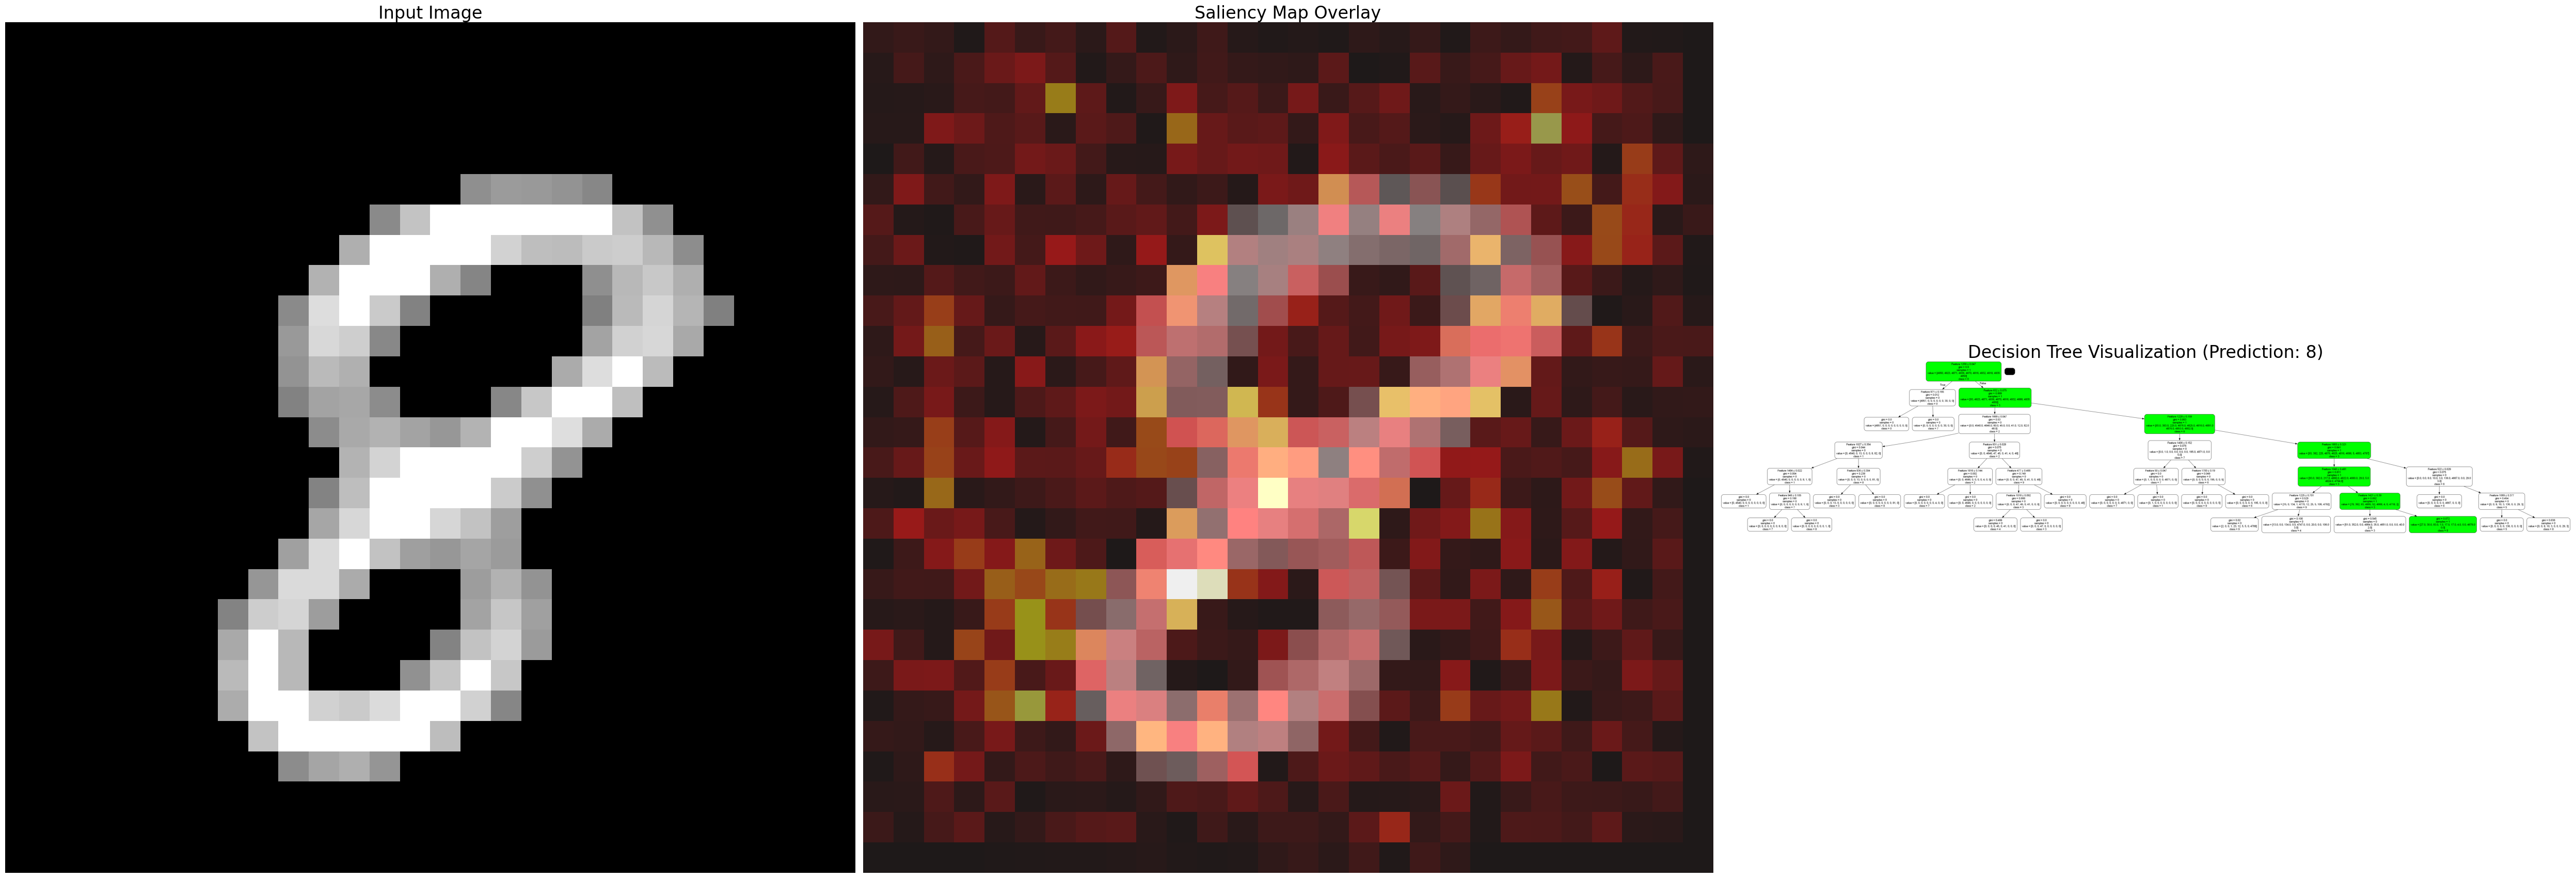

In [49]:
# Load CNN and DT models
cnn_model = load_model("cnn_model.keras")
with open("dt_model.pkl", "rb") as dt_file:
    dt_model = pickle.load(dt_file)

# Get outputs of all layers
layer_outputs = [layer.output for layer in cnn_model.layers]  
grad_model = Model(inputs=cnn_model.inputs, outputs=layer_outputs)

# Select an image to visualize
input_image = np.expand_dims(X_test[20].reshape(28, 28, 1), axis=0)  # Ensure shape (1, 28, 28, 1)


# Function to generate saliency map
def generate_saliency_map(model, img, class_index=None):
    img = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img)
        predictions = model(img)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, img)
    saliency = np.max(np.abs(grads[0]), axis=-1)
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)
    return saliency

# Generate the saliency map
saliency_map = generate_saliency_map(cnn_model, input_image)

# Get feature maps from the gradient model
feature_maps = grad_model.predict(input_image)
cnn_features = feature_maps[-2]
cnn_features_flat = cnn_features.reshape(1, -1)

# DT prediction based on CNN features
dt_prediction = dt_model.predict(cnn_features_flat)
print("Decision Tree Prediction:", dt_prediction)

# Visualize the Decision Tree
dot_data = tree.export_graphviz(
    dt_model,
    out_file=None,
    feature_names=[f'Feature {i}' for i in range(cnn_features_flat.shape[1])],
    class_names=[str(i) for i in np.unique(y_train)],
    filled=True,
    rounded=True,
    special_characters=True,
    fontname="Arial"
)

graph = pydotplus.graph_from_dot_data(dot_data)

# Empty all nodes by setting color to white and samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

# Highlight the nodes on the decision path
decision_paths = dt_model.decision_path(cnn_features_flat)
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
        node.set('label', '<br/>'.join(labels))

# Convert the decision tree visualization to an image
img_data = graph.create_png()
img = Image.open(BytesIO(img_data))
img.save("tree.png")  # Save the image if needed
# Increase the resolution by saving with higher DPI
high_res_img = img.resize((img.width * 3, img.height * 3), Image.LANCZOS)  # Increase scaling factor for better resolution
high_res_img.save("tree_high_res.png")  # Save the image with higher resolution

# Plot all visualizations in a single figure with adjustable zoom
fig, axes = plt.subplots(1, 3, figsize=(50, 25))  # Increase figure size to better fit the larger tree

# Input Image
axes[0].imshow(input_image.reshape(28, 28), cmap='gray')
axes[0].set_title("Input Image", fontsize=24)
axes[0].axis('off')

# Saliency Map
axes[1].imshow(input_image.reshape(28, 28), cmap='gray', alpha=0.8)
axes[1].imshow(saliency_map, cmap='hot', alpha=0.5)
axes[1].set_title("Saliency Map Overlay", fontsize=24)
axes[1].axis('off')

# Decision Tree Visualization
axes[2].imshow(high_res_img)
axes[2].set_title(f"Decision Tree Visualization (Prediction: {dt_prediction[0]})", fontsize=24)
axes[2].axis('off')

plt.tight_layout()
plt.savefig("combined_visualizations_zoomed_high_res.png", dpi=300)  # Save the image with high DPI for clearer details
plt.show()